Loading data...
Calculating seasonal ACC...
  g6sulfur - DJF: mean ACC=0.297
  g6sulfur - MAM: mean ACC=0.278
  g6sulfur - JJA: mean ACC=0.295
  g6sulfur - SON: mean ACC=0.326
  ssp245 - DJF: mean ACC=0.317
  ssp245 - MAM: mean ACC=0.309
  ssp245 - JJA: mean ACC=0.322
  ssp245 - SON: mean ACC=0.350
  Δ-ACC DJF: mean=-0.020
  Δ-ACC MAM: mean=-0.031
  Δ-ACC JJA: mean=-0.027
  Δ-ACC SON: mean=-0.024


/tmp/ipykernel_75563/3452246654.py:298: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1.0, 1.0], h_pad=1.0, w_pad=1.0)


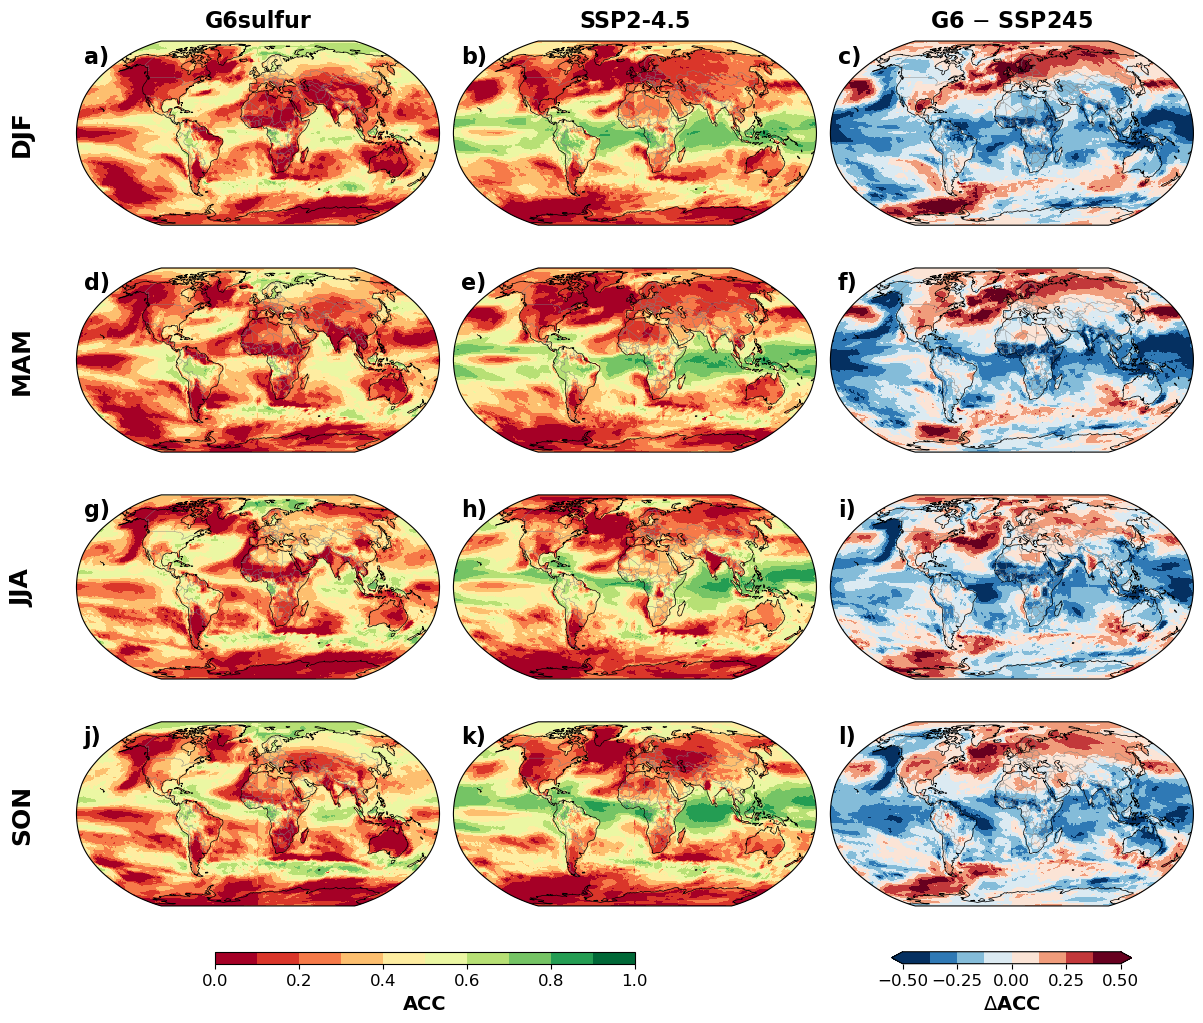

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ----------------------------
# Configuration
# ----------------------------
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")

var_name = 'tas'
scenarios = ['g6sulfur', 'ssp245']
model_key = 'pred_grid'  # PLD-Res

# Seasons
seasons = {
    'DJF': [12, 1, 2],   # December, January, February
    'MAM': [3, 4, 5],    # March, April, May
    'JJA': [6, 7, 8],    # June, July, August
    'SON': [9, 10, 11]   # September, October, November
}

season_labels = ['DJF', 'MAM', 'JJA', 'SON']

# ----------------------------
# Functions
# ----------------------------
def calculate_anomalies_xr(data_array, time_coord):
    """
    Calculate anomalies by subtracting monthly climatology using xarray groupby.
    
    Args:
        data_array: xarray DataArray with time dimension
        time_coord: time coordinate
    
    Returns:
        anomalies: xarray DataArray with anomalies
    """
    # Create temporary DataArray if not already one
    if not isinstance(data_array, xr.DataArray):
        data_array = xr.DataArray(
            data_array,
            coords={'time': time_coord, 'lat': lat, 'lon': lon},
            dims=['time', 'lat', 'lon']
        )
    
    # Calculate monthly climatology using groupby
    climatology = data_array.groupby('time.month').mean('time')
    
    # Calculate anomalies by subtracting climatology
    anomalies = data_array.groupby('time.month') - climatology
    
    return anomalies

def calculate_seasonal_acc(pred_data, truth_data, time, season_months):
    """
    Calculate seasonal Anomaly Correlation Coefficient (ACC).
    
    Args:
        pred_data: (time, lat, lon) prediction array
        truth_data: (time, lat, lon) ground truth array
        time: time coordinate
        season_months: list of months for the season (e.g., [12, 1, 2] for DJF)
    
    Returns:
        seasonal_acc: (lat, lon) array of ACC for the season
    """
    # Create DataArrays
    pred_da = xr.DataArray(
        pred_data,
        coords={'time': time, 'lat': lat, 'lon': lon},
        dims=['time', 'lat', 'lon']
    )
    truth_da = xr.DataArray(
        truth_data,
        coords={'time': time, 'lat': lat, 'lon': lon},
        dims=['time', 'lat', 'lon']
    )
    
    # Calculate anomalies using groupby
    pred_anomalies = calculate_anomalies_xr(pred_da, time)
    truth_anomalies = calculate_anomalies_xr(truth_da, time)
    
    # Select seasonal data
    season_mask = pred_anomalies.time.dt.month.isin(season_months)
    pred_seasonal = pred_anomalies.where(season_mask, drop=True)
    truth_seasonal = truth_anomalies.where(season_mask, drop=True)
    
    # Calculate ACC at each grid point (Pearson correlation)
    n_time, n_lat, n_lon = pred_seasonal.shape
    acc = np.zeros((n_lat, n_lon))
    
    for i in range(n_lat):
        for j in range(n_lon):
            pred_series = pred_seasonal.values[:, i, j]
            truth_series = truth_seasonal.values[:, i, j]
            
            # Skip if all NaN or constant
            if np.all(np.isnan(pred_series)) or np.all(np.isnan(truth_series)):
                acc[i, j] = np.nan
                continue
            
            # Remove NaN values
            mask = ~(np.isnan(pred_series) | np.isnan(truth_series))
            if np.sum(mask) < 3:
                acc[i, j] = np.nan
                continue
            
            pred_clean = pred_series[mask]
            truth_clean = truth_series[mask]
            
            # Check for zero variance
            if np.std(pred_clean) == 0 or np.std(truth_clean) == 0:
                acc[i, j] = np.nan
                continue
            
            # Calculate Pearson correlation
            correlation = np.corrcoef(pred_clean, truth_clean)[0, 1]
            acc[i, j] = correlation
    
    return acc

# ----------------------------
# Load data
# ----------------------------
print("Loading data...")
data = {}

for scenario in scenarios:
    residual_file = results_residual_dir / f"{var_name}_evaluation_{scenario}.nc"
    ds = xr.open_dataset(residual_file)
    
    data[scenario] = {
        'pred': ds[model_key].values,
        'truth': ds['groundtruth'].values,
        'time': ds.time,
        'lat': ds.lat.values,
        'lon': ds.lon.values
    }

# Get coordinates (same for both scenarios)
lat = data['g6sulfur']['lat']
lon = data['g6sulfur']['lon']

# ----------------------------
# Calculate seasonal ACC
# ----------------------------
seasonal_acc = {scenario: {} for scenario in scenarios}

print("Calculating seasonal ACC...")
for scenario in scenarios:
    for season_name, season_months in seasons.items():
        acc = calculate_seasonal_acc(
            data[scenario]['pred'],
            data[scenario]['truth'],
            data[scenario]['time'],
            season_months
        )
        seasonal_acc[scenario][season_name] = acc
        print(f"  {scenario} - {season_name}: mean ACC={np.nanmean(acc):.3f}")

# Calculate delta ACC (G6sulfur - SSP245)
delta_acc = {}
for season_name in season_labels:
    delta_acc[season_name] = seasonal_acc['g6sulfur'][season_name] - seasonal_acc['ssp245'][season_name]
    print(f"  Δ-ACC {season_name}: mean={np.nanmean(delta_acc[season_name]):.3f}")

# ----------------------------
# Create 4x3 subplot figure
# ----------------------------
fig = plt.figure(figsize=(12, 10))

# Colormap settings
# For ACC: use diverging colormap (values from -1 to 1, but typically 0 to 1)
acc_cmap = 'RdYlGn'  # Red-Yellow-Green (red=poor, green=good correlation)
delta_cmap = 'RdBu_r'  # Red-Blue reversed for delta

# Color limits for ACC and delta-ACC
acc_vmin, acc_vmax = 0, 1  # ACC typically ranges from 0 to 1 for good predictions
delta_vmin, delta_vmax = -0.5, 0.5

# Create discrete colormaps
from matplotlib.colors import BoundaryNorm

# ACC: 2 color grids between each tick (0, 0.2, 0.4, 0.6, 0.8, 1.0)
acc_tick_values = np.arange(0, 1.2, 0.2)  # Ticks at 0, 0.2, 0.4, 0.6, 0.8, 1.0
acc_levels = np.arange(0, 1.1, 0.1)  # 2 grids between each tick
acc_norm = BoundaryNorm(acc_levels, ncolors=256)

# Delta-ACC: 2 color grids between each tick
delta_tick_values = np.arange(-0.5, 0.6, 0.25)  # Ticks at -0.5, -0.25, 0, 0.25, 0.5
delta_levels = np.arange(-0.5, 0.525, 0.125)  # 2 grids between each tick
delta_norm = BoundaryNorm(delta_levels, ncolors=256)

# Panel labels
panel_labels = [chr(97 + i) + ')' for i in range(12)]  # a) through l)

# Create meshgrid for plotting
lon_2d, lat_2d = np.meshgrid(lon, lat)

# Plot 4 rows (seasons) x 3 columns (G6sulfur, SSP245, Delta)
for row_idx, season_name in enumerate(season_labels):
    
    # Column 1: G6sulfur ACC
    ax1 = fig.add_subplot(4, 3, row_idx * 3 + 1, projection=ccrs.Robinson())
    acc_g6 = seasonal_acc['g6sulfur'][season_name]
    
    im1 = ax1.pcolormesh(lon_2d, lat_2d, acc_g6,
                        transform=ccrs.PlateCarree(),
                        cmap=acc_cmap, norm=acc_norm,
                        shading='auto')
    
    ax1.coastlines(linewidth=0.5, color='black')
    ax1.add_feature(cfeature.BORDERS, linewidth=0.3, edgecolor='gray')
    ax1.set_global()
    
    if row_idx == 0:
        ax1.set_title('G6sulfur', fontsize=16, fontweight='bold', pad=10)
    
    # Add season label on left
    ax1.text(-0.15, 0.5, season_name, 
            transform=ax1.transAxes,
            fontsize=18, fontweight='bold',
            rotation=90, va='center', ha='center')
    
    # Add panel label WITHOUT box
    ax1.text(0.02, 0.98, panel_labels[row_idx * 3], 
            transform=ax1.transAxes,
            fontsize=16, fontweight='bold',
            verticalalignment='top',
            color='black')
    
    # Column 2: SSP245 ACC
    ax2 = fig.add_subplot(4, 3, row_idx * 3 + 2, projection=ccrs.Robinson())
    acc_245 = seasonal_acc['ssp245'][season_name]
    
    im2 = ax2.pcolormesh(lon_2d, lat_2d, acc_245,
                        transform=ccrs.PlateCarree(),
                        cmap=acc_cmap, norm=acc_norm,
                        shading='auto')
    
    ax2.coastlines(linewidth=0.5, color='black')
    ax2.add_feature(cfeature.BORDERS, linewidth=0.3, edgecolor='gray')
    ax2.set_global()
    
    if row_idx == 0:
        ax2.set_title('SSP2-4.5', fontsize=16, fontweight='bold', pad=10)
    
    # Add panel label WITHOUT box
    ax2.text(0.02, 0.98, panel_labels[row_idx * 3 + 1], 
            transform=ax2.transAxes,
            fontsize=16, fontweight='bold',
            verticalalignment='top',
            color='black')
    
    # Column 3: Delta ACC (G6 - SSP245)
    ax3 = fig.add_subplot(4, 3, row_idx * 3 + 3, projection=ccrs.Robinson())
    delta_acc_data = delta_acc[season_name]
    
    im3 = ax3.pcolormesh(lon_2d, lat_2d, delta_acc_data,
                        transform=ccrs.PlateCarree(),
                        cmap=delta_cmap, norm=delta_norm,
                        shading='auto')
    
    ax3.coastlines(linewidth=0.5, color='black')
    ax3.add_feature(cfeature.BORDERS, linewidth=0.3, edgecolor='gray')
    ax3.set_global()
    
    if row_idx == 0:
        ax3.set_title(r'G6 $-$ SSP245', fontsize=16, fontweight='bold', pad=10)
    
    # Add panel label WITHOUT box
    ax3.text(0.02, 0.98, panel_labels[row_idx * 3 + 2], 
            transform=ax3.transAxes,
            fontsize=16, fontweight='bold',
            verticalalignment='top',
            color='black')

# Add colorbars with tighter spacing
# Colorbar for ACC (columns 1 and 2) with specific ticks
cbar_ax1 = fig.add_axes([0.172, 0.016, 0.35, 0.012])
cbar1 = fig.colorbar(im1, cax=cbar_ax1, orientation='horizontal', extend='neither',
                     ticks=acc_tick_values)
cbar1.set_label('ACC', fontsize=14, fontweight='bold')
cbar1.ax.tick_params(labelsize=12)

# Colorbar for delta-ACC (column 3) with specific ticks
cbar_ax2 = fig.add_axes([0.736, 0.016, 0.2, 0.012])
cbar2 = fig.colorbar(im3, cax=cbar_ax2, orientation='horizontal', extend='both',
                     ticks=delta_tick_values)
cbar2.set_label(r'$\Delta$ACC', fontsize=14, fontweight='bold')
cbar2.ax.tick_params(labelsize=12)

# Adjust layout with tighter spacing
plt.tight_layout(rect=[0, 0.03, 1.0, 1.0], h_pad=1.0, w_pad=1.0)

# Save figure
output_file = figures_dir / "g6sulfur_ssp245_acc_map.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
